In [1]:
from microstruktur.signal_models import cylinder_models, gaussian_models
from microstruktur.core import modeling_framework, acquisition_scheme
from microstruktur.utils import utils
import matplotlib.pyplot as plt
%matplotlib inline

# Synthetic Experiment

In [2]:
from microstruktur.data import saved_acquisition_schemes, saved_data
scheme = saved_acquisition_schemes.wu_minn_hcp_acquisition_scheme()

synthetic_data_parallel = saved_data.synthetic_camino_data_parallel()
synthetic_data_dispersed = saved_data.synthetic_camino_data_dispersed()

## Get an intial guess for orientation using Dipy's DTI

In [3]:
from dipy.reconst import dti

gtab = acquisition_scheme.gtab_mipy2dipy(scheme)
tenmod = dti.TensorModel(gtab)
tenfit_parallel = tenmod.fit(synthetic_data_parallel.signal_attenuation)
tenfit_dispersed = tenmod.fit(synthetic_data_dispersed.signal_attenuation)

In [4]:
mu_parallel_cart = tenfit_parallel.directions.squeeze()
mu_dispersed_cart = tenfit_dispersed.directions.squeeze()

In [5]:
from microstruktur.utils.utils import cart2sphere
mu_parallel = utils.cart2mu(mu_parallel_cart)
mu_dispersed = utils.cart2mu(mu_dispersed_cart)

## Generate Ball and Stick model

In [6]:
ball = gaussian_models.G3Ball()
stick = cylinder_models.C1Stick()

BAS_mod = modeling_framework.MultiCompartmentMicrostructureModel(
    acquisition_scheme=scheme,
    models=[stick, ball]
)

## Fit Ball and Stick to data

In [7]:
param_parallel_x0 = BAS_mod.parameter_initial_guess_to_parameter_vector(
    C1Stick_1_mu=mu_parallel  # initialization stick parameters
)
param_dispersed_x0 = BAS_mod.parameter_initial_guess_to_parameter_vector(
    C1Stick_1_mu=mu_dispersed  # initialization stick parameters
)

C1Stick_1_mu successfully set.
C1Stick_1_mu successfully set.


In [8]:
# fitting to parallel (undispersed) data varying diffusivity D=[1.7, 2.0, 2.3]
BAS_fit = BAS_mod.fit(
    synthetic_data_parallel.signal_attenuation,
    parameter_initial_guess=param_parallel_x0)

# fitting to dispersed data varying diffusivity D=[1.7, 2.0, 2.3]
BAS_fit_dispersed = BAS_mod.fit(
    synthetic_data_dispersed.signal_attenuation,
    parameter_initial_guess=param_dispersed_x0)

Using parallel processing with 8 workers.
Starting fitting process
Fitting complete in 4.52911901474 seconds.
Average of 0.013724603075 seconds per voxel.
Using parallel processing with 8 workers.
Starting fitting process
Fitting complete in 30.0210270882 seconds.
Average of 0.0101080899287 seconds per voxel.


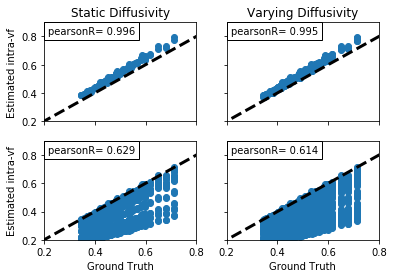

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

saved_data.visualize_correlation_camino_and_estimated_fractions(
    BAS_fit.fitted_parameters['partial_volume_0'].squeeze(),
    BAS_fit_dispersed.fitted_parameters['partial_volume_0'].squeeze())

# Human Connectome Project Example

In [10]:
from microstruktur.data import saved_data
data = saved_data.wu_minn_hcp_coronal_slice()

This data originates from Subject 100307 of the WU-Minn Human Connectome Project. View terms of use at https://store.humanconnectome.org/data/data-use-terms/open-access.php


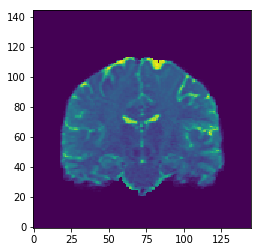

In [11]:
plt.imshow(data[:,0,:,0].T, origin=True)

## Get an intial guess for orientation using Dipy's DTI

In [12]:
tenmod = dti.TensorModel(gtab)
tenfit = tenmod.fit(data, mask=data[..., 0]>0)

In [13]:
mu_cart = tenfit.directions[..., 0, :]
mu = utils.cart2mu(mu_cart)

param_x0 = BAS_mod.parameter_initial_guess_to_parameter_vector(
    C1Stick_1_mu=mu,
)

C1Stick_1_mu successfully set.


/user/rfick/home/anaconda2/lib/python2.7/site-packages/microstruktur-0.1.dev0-py2.7.egg/microstruktur/utils/utils.py:341: RuntimeWarning: invalid value encountered in divide
  mu[..., 0] = np.arccos(xyz[..., 2] / r)  # theta


## Fit Ball and Stick model to HCP data

In [14]:
BAS_fit_hcp = BAS_mod.fit(
    data=data, mask=data[..., 0]>0,
    parameter_initial_guess=param_x0)

Using parallel processing with 8 workers.
Starting fitting process
Fitting complete in 104.189293146 seconds.
Average of 0.0127355204921 seconds per voxel.


## Visualize results

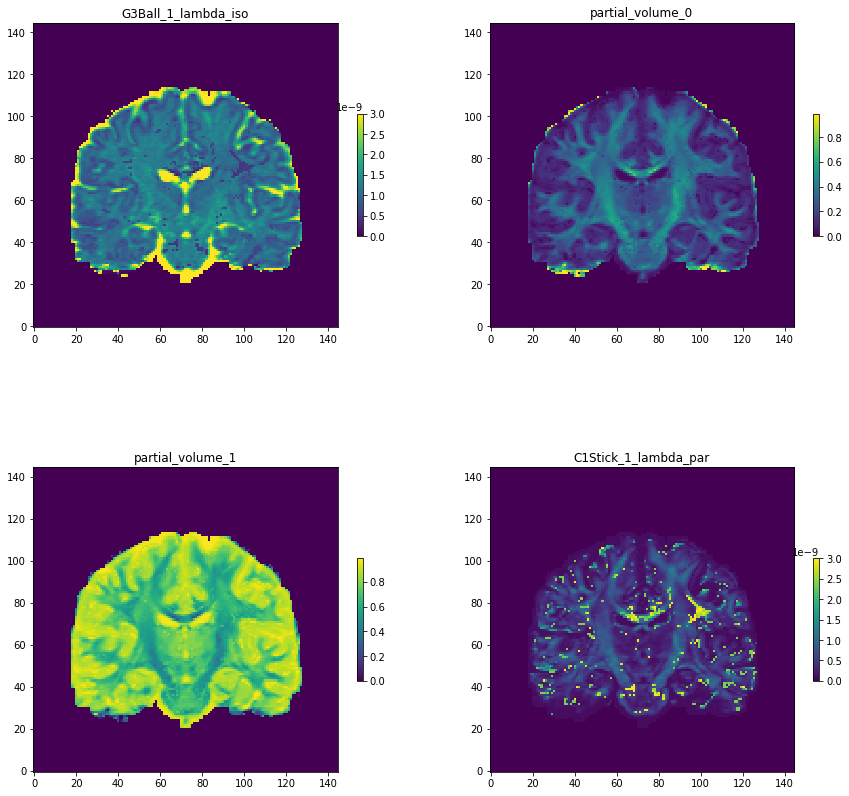

In [15]:
fitted_parameters = BAS_fit_hcp.fitted_parameters

fig, axs = plt.subplots(2, 2, figsize=[15, 15])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters.items():
    if values.squeeze().ndim != 2:
        continue
    cf = axs[counter].imshow(values.squeeze().T, origin=True, interpolation='nearest')
    axs[counter].set_title(name)
    fig.colorbar(cf, ax=axs[counter], shrink=0.33)
    counter += 1

Notice that using this very simple model we get some familiar maps, where the Ball model takes the role of extra-axonal and CSF compartments, and the stick takes the intra-axonal compartment. 

Also notice that the maps are not completely smooth (especially lambda_par) as optimization can still fall in a local minima despite the brute force optimization. 

## Fixing Parameters during optimization

Model parameters are often fixed to a static value to force certain model behaviour. For instance, often parallel diffusivity is fixed to $\lambda_\parallel=1.7e-9m^2/s$. In Mipy, fixing parameters can be easily done by setting the optimization flag for that parameter to False:

In [16]:
param_x0 = BAS_mod.parameter_initial_guess_to_parameter_vector(
    C1Stick_1_mu=mu,
    C1Stick_1_lambda_par=1.7e-9  # now also set initial guess to the fixed value
)

# then set the optimization flag for that parameter to False
BAS_mod.optimized_parameters['C1Stick_1_lambda_par'] = False

# then just proceed as before
BAS_fit_hcp_fixed = BAS_mod.fit(
    data=data, mask=data[..., 0]>0,
    parameter_initial_guess=param_x0)

fitted_parameters_fixed = BAS_fit_hcp_fixed.fitted_parameters

C1Stick_1_mu successfully set.
C1Stick_1_lambda_par successfully set.
Using parallel processing with 8 workers.
Starting fitting process
Fitting complete in 60.9957358837 seconds.
Average of 0.00745577996378 seconds per voxel.


Notice that fitting was now also twice as fast since lambda_par is now not optimized.

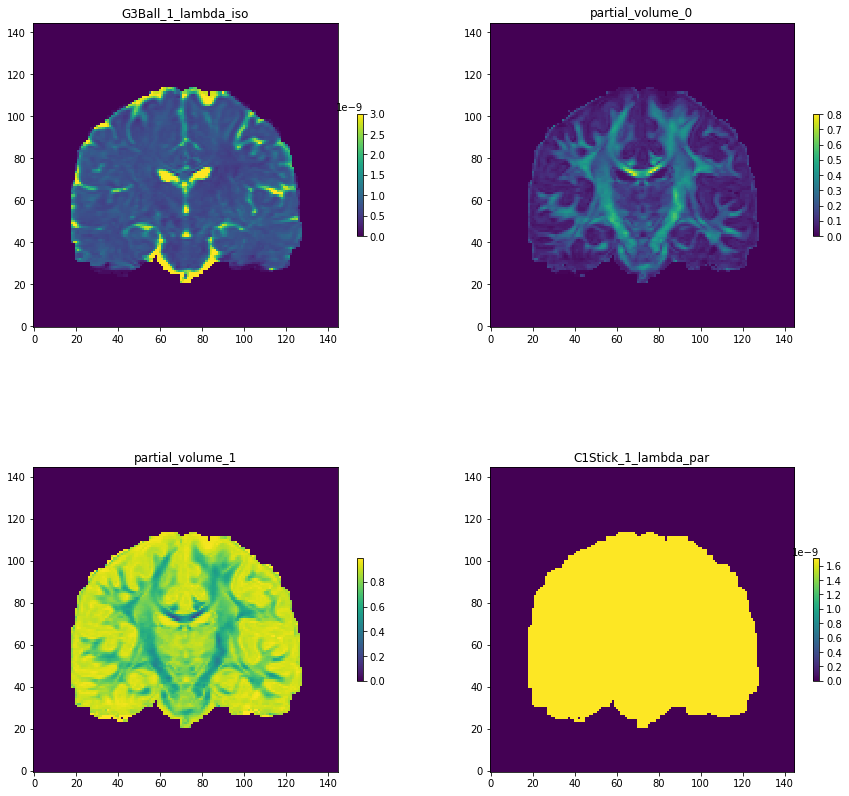

In [17]:
fig, axs = plt.subplots(2, 2, figsize=[15, 15])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters_fixed.items():
    if values.squeeze().ndim != 2:
        continue
    cf = axs[counter].imshow(values.squeeze().T, origin=True, interpolation='nearest')
    axs[counter].set_title(name)
    fig.colorbar(cf, ax=axs[counter], shrink=0.33)
    counter += 1

Notice that nose lambda_par is always set to 1.7e-9, and the other parameters are now optimized while using that constraint. See that lambda_iso and partial_volume are now completely smooth, but will be biased if the parallel diffusivity is not 1.7e-9 in reality.

## Estimating Error Metrics: MSE and $R^2$

Whenever you fit a model, it's always wise to check out the error of the model fit. Here we estimate the Mean Squared Error (MSE) and the $R^2$ coefficient of determination. In MSE the lower is better, while $R^2$ has an upper bound of one, which represents a perfect model fit.

/user/rfick/home/anaconda2/lib/python2.7/site-packages/microstruktur-0.1.dev0-py2.7.egg/microstruktur/core/modeling_framework.py:923: RuntimeWarning: invalid value encountered in true_divide
  data_ = data / self.S0[..., None]
/user/rfick/home/anaconda2/lib/python2.7/site-packages/microstruktur-0.1.dev0-py2.7.egg/microstruktur/core/modeling_framework.py:904: RuntimeWarning: invalid value encountered in true_divide
  data_ = data / self.S0[..., None]


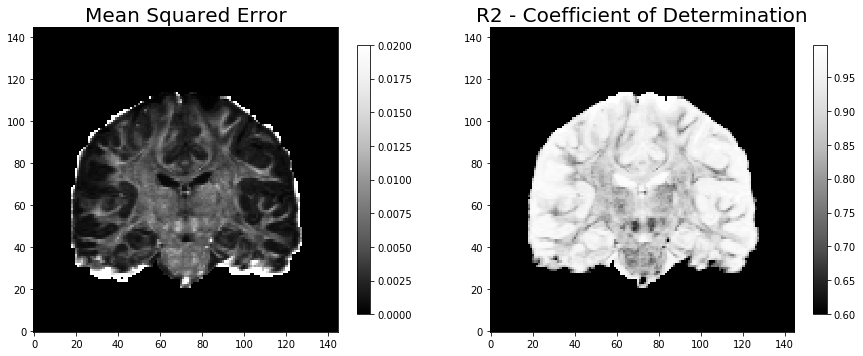

In [18]:
mse = BAS_fit_hcp_fixed.mean_squared_error(data)
R2 = BAS_fit_hcp_fixed.R2_coefficient_of_determination(data)

fig, axs = plt.subplots(1, 2, figsize=[15, 15])
cf = axs[0].imshow(mse.squeeze().T, origin=True, vmax=0.02, cmap='Greys_r')
fig.colorbar(cf, ax=axs[0], shrink=0.33)
axs[0].set_title('Mean Squared Error', fontsize=20)
cf = axs[1].imshow(R2.squeeze().T, origin=True, vmin=0.6, cmap='Greys_r')
fig.colorbar(cf, ax=axs[1], shrink=0.33)
axs[1].set_title('R2 - Coefficient of Determination', fontsize=20);

Ideally, you want the MSE and $R^2$ to show no structure of the underlying data - which would mean the model can at least fit the data equally well everywhere. Instead, in Ball and Stick we can see clearly see the structure of the different brain areas. This means that Ball and Stick model cannot fit the diffusion equally well in all brian areas, and that interpretation of model parameters will be biased when comparing them between these different areas.

When doing these studies, ALWAYS verify whether differences in estimated parameters reflect actual tissue changes, or only reflect the limitations of the model itself.